# LSTM- Long Short Term Memory Network

In [1]:
#Importing Libraries

import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [2]:
#Loading Training Dataset

dataset_train = pd.read_csv("dataset.csv") 
dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4469.932617,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4082.197021,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4111.459473,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4052.931885,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4221.196777,46880000


In [3]:
#Using the Open Stock Price Column to Train the Model

training_set = dataset_train.iloc[:,1:2].values
print(training_set)
print(training_set.shape)

[[ 6000.]
 [ 5800.]
 [ 5750.]
 ...
 [75000.]
 [74800.]
 [    0.]]
(6047, 1)


In [4]:
#Normalizing the Dataset

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler (feature_range = (0,1))
scaled_training_set = scaler.fit_transform(training_set)
scaled_training_set

array([[0.06644518],
       [0.06423034],
       [0.06367663],
       ...,
       [0.83056478],
       [0.82834994],
       [0.        ]])

In [5]:
#Creating X_train and y_train Data Structures

X_train = []
Y_train = []

for i in range(60,1258):
    X_train.append(scaled_training_set[i-60:i, 0])
    Y_train.append(scaled_training_set[i, 0])

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [6]:
print(X_train.shape)
print(Y_train.shape)

(1198, 60)
(1198,)


In [7]:
#Reshape the Data

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1198, 60, 1)

In [8]:
#Importing Libraries for LSTM Model

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [9]:
# Defining a complex LSTM model

regressor = Sequential()

regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=64))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))


In [10]:
# Compile the model with Adam optimizer and mean squared error loss

regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])


In [11]:
# Using early stopping to prevent overfitting

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [12]:
# Training the model with early stopping

history = regressor.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/100
34/34 [==============================] - 20s 219ms/step - loss: 6.3744e-04 - mean_squared_error: 6.3744e-04 - val_loss: 1.2231e-04 - val_mean_squared_error: 1.2231e-04
Epoch 2/100
34/34 [==============================] - 4s 122ms/step - loss: 9.4365e-05 - mean_squared_error: 9.4365e-05 - val_loss: 1.2992e-04 - val_mean_squared_error: 1.2992e-04
Epoch 3/100
34/34 [==============================] - 4s 120ms/step - loss: 8.9570e-05 - mean_squared_error: 8.9570e-05 - val_loss: 6.8277e-05 - val_mean_squared_error: 6.8277e-05
Epoch 4/100
34/34 [==============================] - 4s 122ms/step - loss: 8.0385e-05 - mean_squared_error: 8.0385e-05 - val_loss: 9.2288e-05 - val_mean_squared_error: 9.2288e-05
Epoch 5/100
34/34 [==============================] - 4s 121ms/step - loss: 7.8847e-05 - mean_squared_error: 7.8847e-05 - val_loss: 6.9636e-05 - val_mean_squared_error: 6.9636e-05
Epoch 6/100
34/34 [==============================] - 4s 118ms/step - loss: 7.7058e-05 - mean_squared_err

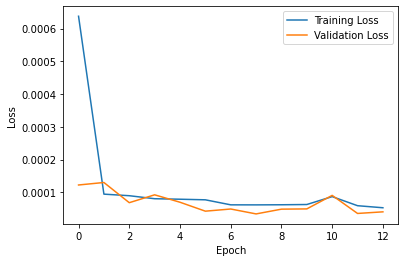

In [13]:
# Plotting training and validation loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Load test dataset

dataset_test = pd.read_csv("dataset.csv")
actual_stock_price = dataset_test.iloc[:, 1:2].values

In [15]:
# Combining train and test datasets to prepare inputs for prediction

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []

In [16]:
# Creating input sequences for prediction

for i in range(60, len(inputs)):
    X_test.append(inputs[i - 60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [17]:
# Making predictions

predicted_stock_price = regressor.predict(X_test)

189/189 [==============================] - 12s 46ms/step


In [18]:
# Inverse scaling to get actual stock prices

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [19]:
# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE) for testing data

test_mse = np.mean(np.square(predicted_stock_price - actual_stock_price))
test_mae = np.mean(np.abs(predicted_stock_price - actual_stock_price))
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)


Test MSE: 22859537.500968315
Test MAE: 2782.497258939092


In [20]:
# Printing the Mean Squared Error (MSE)

train_mse = history.history['loss'][-1]
print("Train MSE:", train_mse)

Train MSE: 5.279506876831874e-05


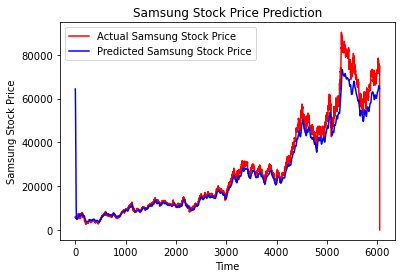

In [21]:
# Plotting

plt.plot(actual_stock_price, color='red', label='Actual Samsung Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Samsung Stock Price')
plt.title('Samsung Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Samsung Stock Price')
plt.legend()
plt.show()

# RNN- Recurrent Neural Network

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


In [23]:
# Load dataset

dataset = pd.read_csv("dataset.csv")

In [24]:
# Preprocess data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset['Open'].values.reshape(-1, 1))

In [25]:
# Split data into training and testing sets

train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

def create_dataset(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)


In [26]:
# Reshape input to be [samples, time steps, features]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [27]:
# Define the RNN model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))


In [28]:
# Compile the model with mean_squared_error as a metric

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])


In [29]:
# Train the model

history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/100
148/148 [==============================] - 29s 143ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 9.5861e-04 - val_mean_squared_error: 9.5861e-04
Epoch 2/100
148/148 [==============================] - 20s 133ms/step - loss: 6.7180e-04 - mean_squared_error: 6.7180e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 3/100
148/148 [==============================] - 20s 135ms/step - loss: 6.5192e-04 - mean_squared_error: 6.5192e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/100
148/148 [==============================] - 17s 112ms/step - loss: 5.8753e-04 - mean_squared_error: 5.8753e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 5/100
148/148 [==============================] - 13s 90ms/step - loss: 4.8624e-04 - mean_squared_error: 4.8624e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 6/100
148/148 [==============================] - 13s 90ms/step - loss: 4.5812e-04 - mean_squared_error: 4.5812e-04 - val_loss

148/148 [==============================] - 23s 154ms/step - loss: 1.9522e-04 - mean_squared_error: 1.9522e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 48/100
148/148 [==============================] - 19s 130ms/step - loss: 2.1152e-04 - mean_squared_error: 2.1152e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 49/100
148/148 [==============================] - 20s 135ms/step - loss: 1.9114e-04 - mean_squared_error: 1.9114e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 50/100
148/148 [==============================] - 19s 127ms/step - loss: 2.1157e-04 - mean_squared_error: 2.1157e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 51/100
148/148 [==============================] - 20s 138ms/step - loss: 2.1282e-04 - mean_squared_error: 2.1282e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 52/100
148/148 [==============================] - 20s 136ms/step - loss: 2.1152e-04 - mean_squared_error: 2.1152e-04 - val_loss: 0.0

Epoch 94/100
148/148 [==============================] - 20s 139ms/step - loss: 1.8049e-04 - mean_squared_error: 1.8049e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 95/100
148/148 [==============================] - 20s 139ms/step - loss: 1.8721e-04 - mean_squared_error: 1.8721e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 96/100
148/148 [==============================] - 19s 128ms/step - loss: 1.7499e-04 - mean_squared_error: 1.7499e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 97/100
148/148 [==============================] - 19s 128ms/step - loss: 1.9508e-04 - mean_squared_error: 1.9508e-04 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 98/100
148/148 [==============================] - 19s 131ms/step - loss: 1.9808e-04 - mean_squared_error: 1.9808e-04 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 99/100
148/148 [==============================] - 19s 129ms/step - loss: 1.9721e-04 - mean_squared_error: 1.9721e-04 - 

In [30]:
# Make predictions

predictions = model.predict(X_test)


35/35 [==============================] - 4s 47ms/step


In [31]:
# Inverse scaling

predictions = scaler.inverse_transform(predictions)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))


In [32]:
# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE) for testing data

test_mse = np.mean(np.square(predictions - Y_test))
test_mae = np.mean(np.abs(predictions - Y_test))
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)


Test MSE: 71643911.31610885
Test MAE: 7524.791362573264


In [33]:
# Print Mean Squared Error (MSE) for training data

train_mse = history.history['mean_squared_error'][-1]
print("Train MSE:", train_mse)


Train MSE: 0.00017887516878545284


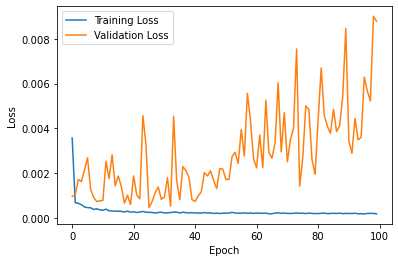

In [35]:
# Plot training and validation loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



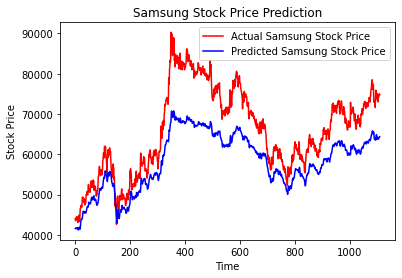

In [36]:
plt.plot(Y_test, color='red', label='Actual Samsung Stock Price')
plt.plot(predictions, color='blue', label='Predicted Samsung Stock Price')
plt.title('Samsung Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()